# CenterNet


In [1]:
import albumentations as A
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from ROI.neural_network import *
from training import initialize_weights

## Prepare dataset for training CenterNet

- Crop black edges from high resolution images
- Pad images and masks to square shape
- Save resulting files to separate directories
- Generate ground truth bounding boxes
- Create CSV file with image and mask paths and bounding boxes


In [3]:
ORIGA_DIR = '../data/Kaggle-ORIGA'
generate_centernet_dataset(
    src_images_dir=ORIGA_DIR + '/Images',
    src_masks_dir=ORIGA_DIR + '/Masks',
    dst_images_dir=ORIGA_DIR + '/Images_Padded',
    dst_masks_dir=ORIGA_DIR + '/Masks_Padded',
)

Generating CenterNet dataset:   0%|          | 0/650 [00:00<?, ?it/s]

In [2]:
CSV_FILE = '../data/centernet.csv'

In [ ]:
generate_ground_truth_bbox_csv(
    images_dir=[
        '../data/ORIGA/TrainImages',
        '../data/ORIGA/TestImages',
        '../data/Drishti/TrainImages',
        '../data/Drishti/TestImages',
    ],
    masks_dir=[
        '../data/ORIGA/TrainMasks',
        '../data/ORIGA/TestMasks',
        '../data/Drishti/TrainMasks',
        '../data/Drishti/TestMasks',
    ],
    csv_file=CSV_FILE,
    margin=16,
)

## Model & dataset configuration

- Split dataset into training and validation sets
- Set hyper-parameters
- Data augmentation
- Create datasets and dataloaders


In [3]:
df = pd.read_csv(CSV_FILE)
train_df, val_df = train_test_split(df, test_size=0.05, random_state=48)
print('Training size:', len(train_df))
print('Validation size:', len(val_df))
df.head()

Training size: 675
Validation size: 76


,image_id,mask_id,x,y,w,h
0,..\data\ORIGA\TrainImages/001.jpg,..\data\ORIGA\TrainMasks/001.png,1335.0,1031.0,411.0,497.0
1,..\data\ORIGA\TrainImages/002.jpg,..\data\ORIGA\TrainMasks/002.png,843.0,872.0,385.0,475.0
2,..\data\ORIGA\TrainImages/003.jpg,..\data\ORIGA\TrainMasks/003.png,759.0,955.0,422.0,436.0
3,..\data\ORIGA\TrainImages/004.jpg,..\data\ORIGA\TrainMasks/004.png,1460.0,1060.0,360.0,406.0
4,..\data\ORIGA\TrainImages/005.jpg,..\data\ORIGA\TrainMasks/005.png,741.0,1026.0,407.0,423.0


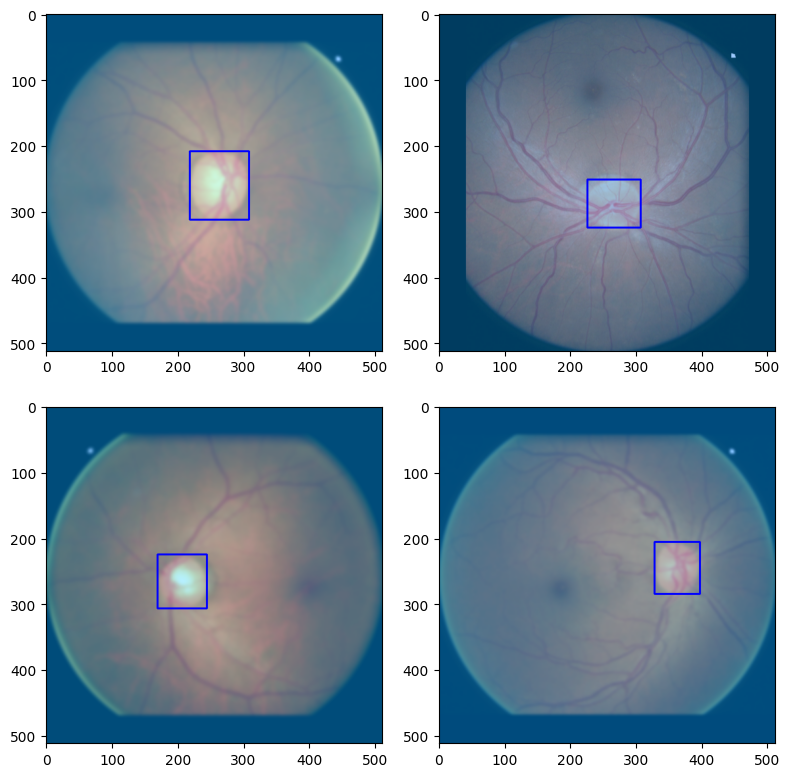

In [6]:
INPUT_SIZE = 512
MODEL_SCALE = 4
BATCH_SIZE = 8

train_transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE, interpolation=cv.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.GaussianBlur(p=0.5, blur_limit=(5, 15)),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

val_transform = A.Compose([
    A.Resize(INPUT_SIZE, INPUT_SIZE, interpolation=cv.INTER_AREA),
    A.Normalize(mean=(0.9400, 0.6225, 0.3316), std=(0.1557, 0.1727, 0.1556)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

res = []
dataset = CenterNetDataset(df, INPUT_SIZE, MODEL_SCALE, train_transform)
for i in range(4):
    index = np.random.randint(0, len(dataset))
    img, heatmap, regression, bboxes, *_ = dataset[index]
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    for bbox in bboxes:
        x, y, w, h = [int(v) for v in bbox]
        img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    res.append(img)
_, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, img in enumerate(res):
    ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [14]:
train_dataset = CenterNetDataset(train_df, INPUT_SIZE, MODEL_SCALE, train_transform)
val_dataset = CenterNetDataset(val_df, INPUT_SIZE, MODEL_SCALE, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Train model

- Initialize model, optimizer, loss function and scheduler
- Train model
- Plot training history
- Save model


In [15]:
MODEL_PATH = r'.\models\centernet.pth'
LEARNING_RATE = 1e-4
EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
SCHEDULER_PATIENCE = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CenterNet(n_classes=1, scale=MODEL_SCALE, base='resnet18', custom=True)
if MODEL_PATH:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print('Model loaded from', MODEL_PATH)
else:
    initialize_weights(model)
model = model.to(DEVICE)

criterion = CenterLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=SCHEDULER_PATIENCE, verbose=True)

Model loaded from .\models\centernet.pth


In [ ]:
hist, best_weights = fit(
    model, optimizer, criterion, DEVICE, train_loader, val_loader,
    epochs=EPOCHS, scheduler=scheduler, early_stopping_patience=EARLY_STOPPING_PATIENCE,
)
print([k for k in hist.keys()])

In [ ]:
avg_loss = np.mean(hist['train_loss']) + np.mean(hist['val_loss'])

plt.figure(figsize=(8, 8))
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.ylim(0, avg_loss * 2)
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')
torch.save(best_weights, 'best_model.pth')

## Create cropped RoI dataset

- Detect square regions of interest in all images
- Generate cropped RoI dataset for segmentation models


In [9]:
image_names = sorted(df['image_id'].unique())
mask_names = sorted(df['mask_id'].unique())
DATA_DIR = '../data/Kaggle-ORIGA'

generate_roi_dataset(
    model, image_names, mask_names, DATA_DIR + '/Images_CenterNet_Cropped', DATA_DIR + '/Masks_CenterNet_Cropped',
    val_transform, INPUT_SIZE, DEVICE, small_margin=16, large_margin=0, roi_size=512,
)

Generating RoI dataset:   0%|          | 0/650 [00:00<?, ?it/s]

## Make predictions

- Load new image
- Predict bounding boxes


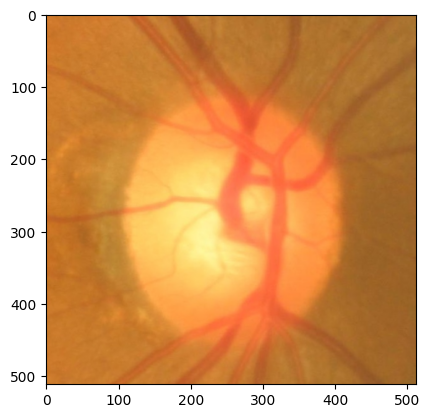

In [17]:
new_file = r"..\data\Kaggle-ORIGA\Images\055.jpg"

new_img = preprocess_centernet_input(new_file)
roi_image, _ = detect_roi(
    model, new_img, None, val_transform, INPUT_SIZE,
    device=DEVICE, small_margin=16, roi_size=512,
)

plt.imshow(roi_image)
plt.show()